In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import load_model

In [19]:
imagePaths = list(paths.list_images('C:/Users/jayad/ENEL 645/Mask_detection/dataset/'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

C:\Users\jayad\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [21]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [22]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
102/102 [==============================] - 141s 1s/step - loss: 0.5923 - accuracy: 0.7208 - val_loss: 0.1873 - val_accuracy: 0.9707
Epoch 2/20
102/102 [==============================] - 125s 1s/step - loss: 0.1989 - accuracy: 0.9575 - val_loss: 0.0978 - val_accuracy: 0.9841
Epoch 3/20
102/102 [==============================] - 123s 1s/step - loss: 0.1094 - accuracy: 0.9735 - val_loss: 0.0724 - val_accuracy: 0.9853
Epoch 4/20
102/102 [==============================] - 130s 1s/step - loss: 0.1018 - accuracy: 0.9711 - val_loss: 0.0643 - val_accuracy: 0.9866
Epoch 5/20
102/102 [==============================] - 140s 1s/step - loss: 0.0753 - accuracy: 0.9798 - val_loss: 0.0523 - val_accuracy: 0.9878
Epoch 6/20
102/102 [==============================] - 124s 1s/step - loss: 0.0744 - accuracy: 0.9824 - val_loss: 0.0523 - val_accuracy: 0.9841
Epoch 7/20
102/102 [==============================] - 116s 1s/step - loss: 0.0611 - accuracy

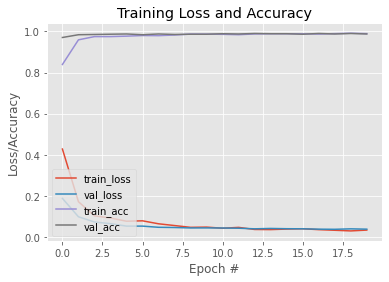

In [23]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [24]:
#To save the trained model
#model.save('mask_recog_ver2.h5') #--> Version 2
model.save('mask_recog_ver3.h5') #--> Version 3

In [9]:
#model = load_model('mask_recog_ver2.h5')

In [42]:
pred = model.predict(testX)
pred1 = np.argmax(pred,axis=1)
y_test = np.argmax(testY,axis=1)

In [43]:
confsn_matrix = confusion_matrix(y_test,pred1)

In [45]:
print(conf_matrix)

[[428   5]
 [  5 381]]


In [54]:
print('Accuracy Score: ', accuracy_score(y_te,pred1))

Accuracy Score:  0.9877899877899878
